In [272]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy.stats import uniform, randint
from keras.models import Sequential 
from keras.layers import Dense
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay 
from sklearn.model_selection import train_test_split
import joblib
from sklearn.model_selection import train_test_split,RandomizedSearchCV

In [273]:
file_path = 'sampled_data2.csv'
df = pd.read_csv(file_path)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [274]:
columns = ([
    'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 
    'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 
    'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 
    'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 
    'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 
    'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 
    'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 
    'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 
    'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 
    'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 
    'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 
    'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 
    'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 
    'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 
    'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 
    'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 
    'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 
    'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 
    'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 
    'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 
    'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max', 
    'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 
    'Label'
])

df.columns = columns
test_df.columns = columns



In [275]:
test_df.isnull().values.any()

False

In [276]:
df.isnull().values.any()

False

In [277]:
df['Label'].value_counts()


Label
Probe         7716
DoS           4653
DDoS          4252
Normal        4121
DDoS          3874
BFA            221
BOTNET         102
Web-Attack      50
U2R             11
Name: count, dtype: int64

In [278]:
test_df['Label'].value_counts()

Label
Probe         1586
DoS            923
DDoS           842
Normal         825
DDoS           756
BFA             40
BOTNET          17
Web-Attack       9
U2R              2
Name: count, dtype: int64

In [279]:

dos_attacks = ['DoS', 'DDoS'] 
probe_attacks = ['Probe']    
privilege_attacks = ['U2R']    
access_attacks = ['BFA', 'Web-Attack', 'BOTNET']  

In [280]:

df['attack_category'] = df['Label'].apply(
    lambda x: 'dos' if x in dos_attacks else (
        'probe' if x in probe_attacks else (
            'privilege' if x in privilege_attacks else (
                'access' if x in access_attacks else 'normal'
            )
        )
    )
)


test_df['attack_category'] = test_df['Label'].apply(
    lambda x: 'dos' if x in dos_attacks else (
        'probe' if x in probe_attacks else (
            'privilege' if x in privilege_attacks else (
                'access' if x in access_attacks else 'normal'
            )
        )
    )
)

In [281]:
df.drop(['Label'],axis=1,inplace=True)
test_df.drop(['Label'],axis=1,inplace=True)

In [282]:
df.shape
test_df.shape

(5000, 84)

In [283]:
lab = LabelEncoder()
df['Flow ID'] = lab.fit_transform(df['Flow ID'])
df['Src IP'] = lab.fit_transform(df['Src IP'])
df['Dst IP'] = lab.fit_transform(df['Dst IP'])
df['Timestamp'] = lab.fit_transform(df['Timestamp'])
df['attack_category'] = lab.fit_transform(df['attack_category'])
test_df['Flow ID'] = lab.fit_transform(test_df['Flow ID'])
test_df['Src IP'] = lab.fit_transform(test_df['Src IP'])
test_df['Dst IP'] = lab.fit_transform(test_df['Dst IP'])
test_df['Timestamp'] = lab.fit_transform(test_df['Timestamp'])
test_df['attack_category'] = lab.fit_transform(test_df['attack_category'])


df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            25000 non-null  int32  
 1   Src IP             25000 non-null  int32  
 2   Src Port           25000 non-null  float64
 3   Dst IP             25000 non-null  int32  
 4   Dst Port           25000 non-null  float64
 5   Protocol           25000 non-null  float64
 6   Timestamp          25000 non-null  int32  
 7   Flow Duration      25000 non-null  float64
 8   Tot Fwd Pkts       25000 non-null  float64
 9   Tot Bwd Pkts       25000 non-null  float64
 10  TotLen Fwd Pkts    25000 non-null  float64
 11  TotLen Bwd Pkts    25000 non-null  float64
 12  Fwd Pkt Len Max    25000 non-null  float64
 13  Fwd Pkt Len Min    25000 non-null  float64
 14  Fwd Pkt Len Mean   25000 non-null  float64
 15  Fwd Pkt Len Std    25000 non-null  float64
 16  Bwd Pkt Len Max    250

In [284]:
# Retrieve the mapping of encoded labels to original categories
mapping = {index: category for index, category in enumerate(lab.classes_)}

# Print the mapping
print(mapping)

{0: 'access', 1: 'dos', 2: 'normal', 3: 'privilege', 4: 'probe'}


In [285]:
corr = df.corr()['attack_category']
corr = corr.drop(['attack_category'])

# Set thresholds for correlation coefficients
high_threshold = 0.5  # Threshold for highly correlated features
low_threshold = 0.1   # Threshold for low correlated features

# Find highly correlated features
highly_correlated_features = corr[abs(corr) > high_threshold].index.tolist()

# Find low correlated features
low_correlated_features = corr[abs(corr) < low_threshold].index.tolist()

In [286]:
selected_features = highly_correlated_features + low_correlated_features

In [287]:
print(highly_correlated_features)
print(low_correlated_features)

['FIN Flag Cnt']
['Src IP', 'Dst IP', 'Timestamp', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Var', 'RST Flag Cnt', 'PSH Flag Cnt', 'Down/Up Ratio', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Std']


In [288]:
data = df.drop(columns=selected_features)

In [289]:
data.shape

(25000, 36)

In [290]:
X = data.iloc[:,:-1]
X.shape

(25000, 35)

In [291]:
y = data.iloc[:,-1]
y.shape

(25000,)

In [292]:

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [293]:
joblib.dump(X_train, 'X_train')
joblib.dump(X_test,'X_test')
joblib.dump(y_train,'y_train')
joblib.dump(y_test, 'y_test')

['y_test']

In [294]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.fit_transform(X_test)

param_dist = {
    'C': uniform(0.1, 10),  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'degree': randint(1, 5),  # Degree of the polynomial kernel function (if 'poly')
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'coef0': uniform(0, 1)  # Independent term in kernel function
}

In [295]:
svm = SVC()

In [296]:
random_search = RandomizedSearchCV(
    svm,
    param_distributions=param_dist,
    n_iter=10,  # Lesser number of iterations for faster processing
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [297]:
random_search.fit(X_scaled_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022C03C9CB60>,
                                        'coef0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022C070F53A0>,
                                        'degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022C5293CFB0>,
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=42, verbose=2)

In [298]:
best_svm = random_search.best_estimator_

best_svm

SVC(C=8.761761457749351, coef0=0.6011150117432088, degree=4, kernel='poly')

In [299]:
# Evaluate the best SVM model on the test set
y_pred_best_svm = best_svm.predict(X_scaled_test)

In [300]:
joblib.dump(best_svm, 'best_svm_model.joblib')
best_svm_loaded = joblib.load('best_svm_model.joblib')
y_pred_loaded_svm = best_svm_loaded.predict(X_scaled_test)
print("Classification Report for Loaded SVM Model:")
print(classification_report(y_test, y_pred_loaded_svm))

Classification Report for Loaded SVM Model:
              precision    recall  f1-score   support

           0       0.95      0.56      0.70        66
           1       0.93      0.97      0.95      1765
           2       0.96      0.91      0.93      1581
           3       0.33      0.50      0.40         2
           4       0.97      0.99      0.98      1586

    accuracy                           0.95      5000
   macro avg       0.83      0.79      0.79      5000
weighted avg       0.95      0.95      0.95      5000



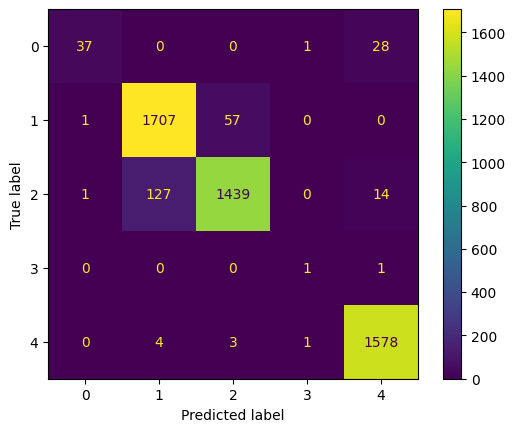

In [301]:
print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred_loaded_svm))

In [302]:
print(confusion_matrix(y_test,y_pred_loaded_svm))

[[  37    0    0    1   28]
 [   1 1707   57    0    0]
 [   1  127 1439    0   14]
 [   0    0    0    1    1]
 [   0    4    3    1 1578]]


ANN

In [303]:
from keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=5)  # Ensure 5 classes
y_test_cat = to_categorical(y_test, num_classes=5)


In [304]:
num_classes = 5  

ann = Sequential()
ann.add(Dense(X_train.shape[1], activation='relu'))
ann.add(Dense(X_train.shape[1], activation='relu'))
ann.add(Dense(X_train.shape[1], activation='relu'))
ann.add(Dense(X_train.shape[1], activation='relu'))
ann.add(Dense(num_classes, activation='softmax'))

In [305]:
ann.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [306]:
ann.fit(X_scaled_train, y_train_cat, batch_size=50, epochs=50)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 755us/step - accuracy: 0.7059 - loss: 0.7976
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.9238 - loss: 0.1957
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.9258 - loss: 0.1616
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.9362 - loss: 0.1367
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.9395 - loss: 0.1211
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.9424 - loss: 0.1118
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.9399 - loss: 0.1162
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.9456 - loss: 0.1085
Epoch 9/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.9458 - loss: 0.1035
Epoch 10/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9472 - loss: 0.1037
Epoch 11/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.9463 - loss: 0.0972
Epoch 12/50
400/400 ━━━━━━━━━━━━

In [307]:
joblib.dump(ann, 'ann_model')

['ann_model']

In [308]:
loss,accuracy = ann.evaluate(X_scaled_train,y_train_cat)
print('Loss',loss)
print('Accuracy',accuracy)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.9559 - loss: 0.0815
Loss 0.08087510615587234
Accuracy 0.9558500051498413


In [309]:
ann_loaded = joblib.load('ann_model')
y_pred_ann = ann_loaded.predict(X_scaled_test)
y_pred_ann

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step


array([[8.4650310e-05, 4.9022475e-04, 9.9942493e-01, 1.8558344e-08,
        1.2744184e-07],
       [1.3190531e-07, 2.6188663e-05, 8.7152412e-12, 2.4903523e-08,
        9.9997365e-01],
       [5.2072726e-05, 2.2779652e-03, 9.9717546e-01, 1.2633532e-06,
        4.9315696e-04],
       ...,
       [2.0707112e-05, 6.1962218e-08, 1.7343042e-06, 5.2792296e-07,
        9.9997687e-01],
       [1.5803185e-07, 2.5935427e-05, 5.4048290e-11, 1.0258104e-07,
        9.9997389e-01],
       [4.5951610e-04, 5.4716605e-01, 4.5177960e-01, 3.5937239e-05,
        5.5884320e-04]], dtype=float32)

In [310]:
y_pred_ann = np.argmax(y_pred_ann, axis=1)
y_test_class = np.argmax(y_test_cat, axis=1)
print("Classification Report for Loaded ANN Model:")
print(classification_report(y_test_class, y_pred_ann))

Classification Report for Loaded ANN Model:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86        66
           1       0.91      1.00      0.95      1765
           2       0.99      0.89      0.94      1581
           3       1.00      0.50      0.67         2
           4       0.99      1.00      0.99      1586

    accuracy                           0.96      5000
   macro avg       0.97      0.83      0.88      5000
weighted avg       0.96      0.96      0.96      5000



Confusion Matrix:
[[  52    0    6    0    8]
 [   0 1764    1    0    0]
 [   3  175 1401    0    2]
 [   0    0    0    1    1]
 [   0    4    3    0 1579]]


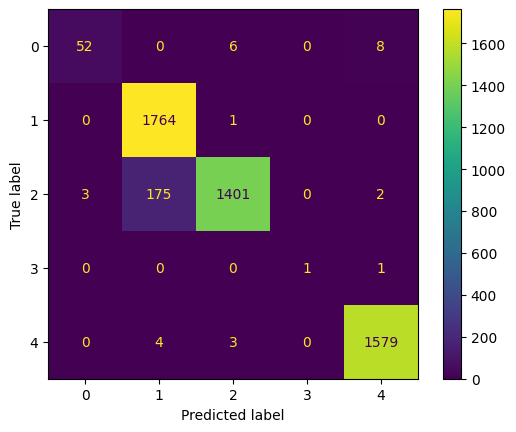

In [311]:
cm = confusion_matrix(y_test_class, y_pred_ann)
print("Confusion Matrix:")
print(cm)

# Optionally, display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [312]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


In [313]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class KerasWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        y_cat = to_categorical(y)
        self.model.fit(X, y_cat, batch_size=50, epochs=50)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

# Wrap your ANN model
ann_estimator = KerasWrapper(ann_loaded)

In [314]:
estimators = [('svm', best_svm_loaded),('ann', ann_estimator)]

In [315]:
stacking_ensemble = StackingClassifier(estimators= estimators, final_estimator= LogisticRegression())

In [316]:
stacking_ensemble.fit(X_scaled_train, y_train)


Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - accuracy: 0.9554 - loss: 0.0847
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.9589 - loss: 0.0787
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.9569 - loss: 0.0809
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.9522 - loss: 0.0887
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.9512 - loss: 0.0929
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.9538 - loss: 0.0855
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.9533 - loss: 0.0870
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.9543 - loss: 0.0807
Epoch 9/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.9554 - loss: 0.0858
Epoch 10/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.9558 - loss: 0.0840
Epoch 11/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.9581 - loss: 0.0805
Epoch 12/50
400/400 ━━━━━━━━━━

StackingClassifier(estimators=[('svm',
                                SVC(C=8.761761457749351,
                                    coef0=0.6011150117432088, degree=4,
                                    kernel='poly')),
                               ('ann',
                                KerasWrapper(model=<Sequential name=sequential_5, built=True>))],
                   final_estimator=LogisticRegression())

In [317]:
joblib.dump(stacking_ensemble, 'stacking_ensemble_model')

['stacking_ensemble_model']

In [318]:
ensemble_loaded = joblib.load('stacking_ensemble_model')
y_pred_stack = ensemble_loaded.predict(X_scaled_test)
y_pred_stack

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step


array([2, 4, 2, ..., 4, 4, 1])

In [319]:
print(classification_report(y_test,y_pred_stack))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86        66
           1       0.93      0.97      0.95      1765
           2       0.96      0.92      0.94      1581
           3       0.33      0.50      0.40         2
           4       0.99      1.00      0.99      1586

    accuracy                           0.96      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.96      0.96      0.96      5000



In [320]:
report = classification_report(y_test, y_pred_stack, target_names=['access', 'dos', 'normal', 'privilege', 'probe'])
print(report)

              precision    recall  f1-score   support

      access       0.95      0.79      0.86        66
         dos       0.93      0.97      0.95      1765
      normal       0.96      0.92      0.94      1581
   privilege       0.33      0.50      0.40         2
       probe       0.99      1.00      0.99      1586

    accuracy                           0.96      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.96      0.96      0.96      5000



Model Evaluation

In [321]:
X_new = np.array([
    [164.248204, 192.1683, 0, 0, 0, 0.0, 0.0, 2.0, 0.0, 2.0, 200000, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
])

In [322]:
scaler_new = StandardScaler()
X_new_scaled = scaler_new.fit_transform(X_new)
y_new = best_svm_loaded.predict(X_new_scaled)
pred = lab.inverse_transform(y_new)
print("SVM Class:", pred.item())

SVM Class: normal


In [323]:
y_new2 = ann_loaded.predict(X_new_scaled)
ind = y_new2.argmax()
pred_ann = lab.inverse_transform([ind])
print("ANN Class:", pred_ann.item())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
ANN Class: normal


In [324]:
y_new_stack = ensemble_loaded.predict(X_new_scaled)
pred_stack = lab.inverse_transform(y_new_stack)
print("Stacking Ensemble Class:", pred_stack.item())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Stacking Ensemble Class: normal
